# Modelos: KNN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH                  = '../..'
LIB_PATH                   = f'{BASE_PATH}/lib'
DATASET_PATH               = f'{BASE_PATH}/datasets'
STACKING_PATH              = f'{DATASET_PATH}/stacking'
WEIGHTS_PATH               = f'{BASE_PATH}/weights'

METRICS_PATH                   = f'{BASE_PATH}/metrics/knn'

USER_STACKING_TRAIN_PATH     = f'{STACKING_PATH}/knn_user_train.json'
ITEM_STACKING_TRAIN_PATH     = f'{STACKING_PATH}/knn_item_train.json'
ENSEMBLE_STACKING_TRAIN_PATH = f'{STACKING_PATH}/knn_ensemble_train.json'

USER_STACKING_TEST_PATH     = f'{STACKING_PATH}/knn_user_test.json'
ITEM_STACKING_TEST_PATH     = f'{STACKING_PATH}/knn_item_test.json'
ENSEMBLE_STACKING_TEST_PATH = f'{STACKING_PATH}/knn_ensemble_test.json'

In [3]:
import sys
sys.path.append(LIB_PATH)

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import pytorch_common.util as pu

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import util as ut

import random

import util as ut

ModuleNotFoundError: No module named 'plotly'

<Figure size 640x480 with 0 Axes>

## Setup

In [ ]:
ut.mkdir(STACKING_PATH)

In [ ]:
import pytorch_common
pytorch_common.__version__

In [ ]:
torch.__version__

In [ ]:
pu.LoggerBuilder().on_console().build()

In [ ]:
pu.set_device_name('gpu')

pu.get_device(), torch.cuda.is_available()

In [ ]:
ut.set_seed(42)

In [ ]:
TRAIN        = True
N_NEIGHTBORS = 1000

In [ ]:
def build_stacking_df(
    predictor,
    ds,
    n_neighbors = 1000,
    batch_size  = 500,
    num_workers = 24,
    pin_memory  = True
):
    dl = DataLoader(
        ds,
        batch_size  = batch_size,
        num_workers = num_workers,
        pin_memory  = pin_memory
    )

    return pd.DataFrame({
        'user_id'	 : ds.data['user_id'],
        'movie_id'   : ds.data['movie_id'],
        'rating'     : ds.data['user_movie_rating'],
        'prediction' : predictor.predict_dl(dl, n_neighbors).numpy()
    })

In [ ]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

## Carga de dataset

In [ ]:
dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    path             = DATASET_PATH,
    transform        = features_fn,
    target_transform = target_fn,
    device           = torch.device('cpu'),
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2004)]
)

train_set, eval_test_set, rating_mean_df, rating_std = dataset.train_test_split(split_year=2016)

eval_set, test_set, _, _ = eval_test_set.train_test_split(
    split_year     = 2018, 
    rating_mean_df = rating_mean_df, 
    rating_std     = rating_std
)

train_set.shape, eval_set.shape, test_set.shape

In [ ]:
train_set.data.head(2)

## Entrenamiento del modelo

In [27]:
if TRAIN:
    user_predictor = ml.KNNUserBasedPredictor.from_data_frame(
        data          = train_set.data,
        user_seq_col  = 'user_seq',
        item_seq_col  = 'movie_seq',
        rating_col    = 'user_movie_rating',
        distance      = ml.CosineDistance()
    )

Building Ratting Matrix:   0%|          | 0/125905 [00:00<?, ?it/s]

Building Distances Matrix:   0%|          | 0/12854 [00:00<?, ?it/s]

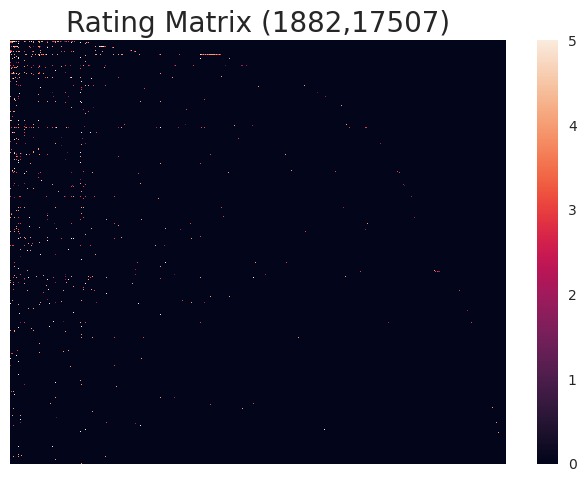

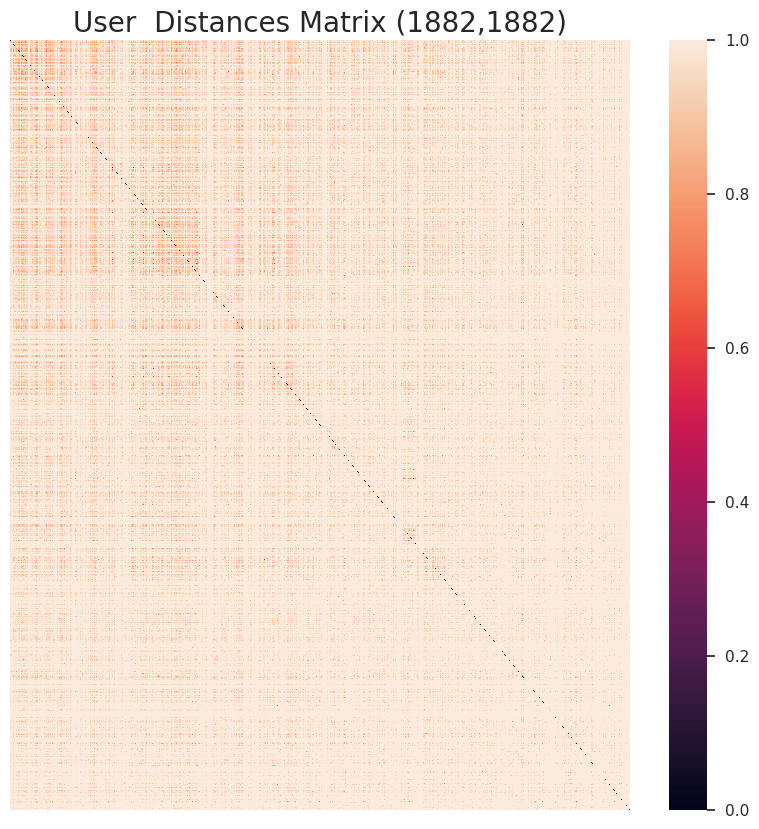

In [15]:
if TRAIN:
    user_predictor.plot()

In [28]:
dir(user_predictor)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 'delete',
 'from_data_frame',
 'from_file',
 'from_rm',
 'name',
 'nn',
 'plot',
 'predict',
 'predict_batch',
 'predict_dl',
 'rm',
 'save']

In [16]:
if TRAIN:
    item_predictor = ml.KNNItemBasedPredictor.from_data_frame(
        data          = train_set.data,
        user_seq_col  = 'user_seq',
        item_seq_col  = 'movie_seq',
        rating_col    = 'user_movie_rating',
        distance      = ml.CosineDistance()
    )

Building Ratting Matrix:   0%|          | 0/99934 [00:00<?, ?it/s]

Building Distances Matrix:   0%|          | 0/17507 [00:00<?, ?it/s]

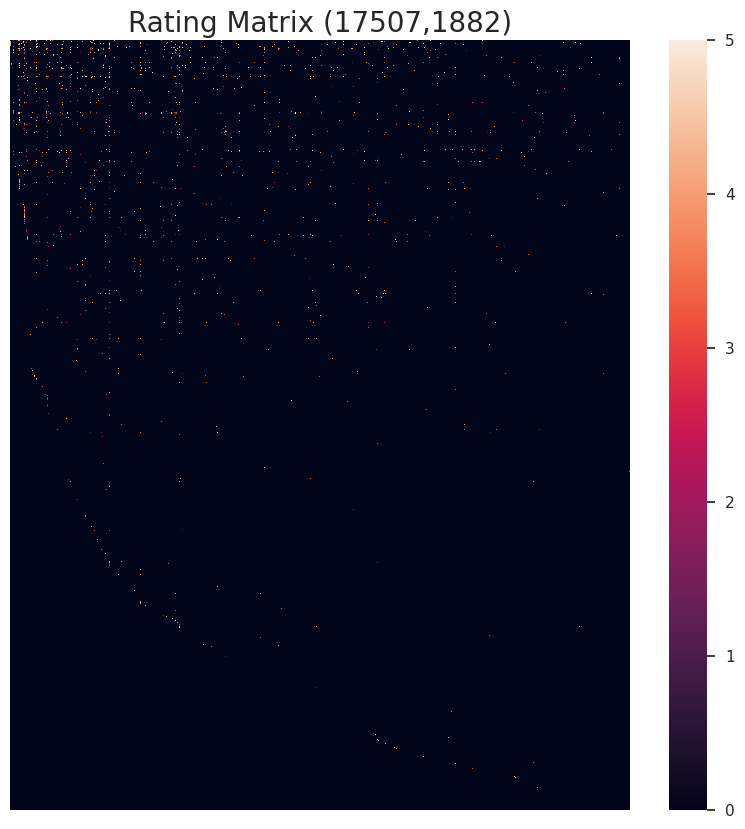

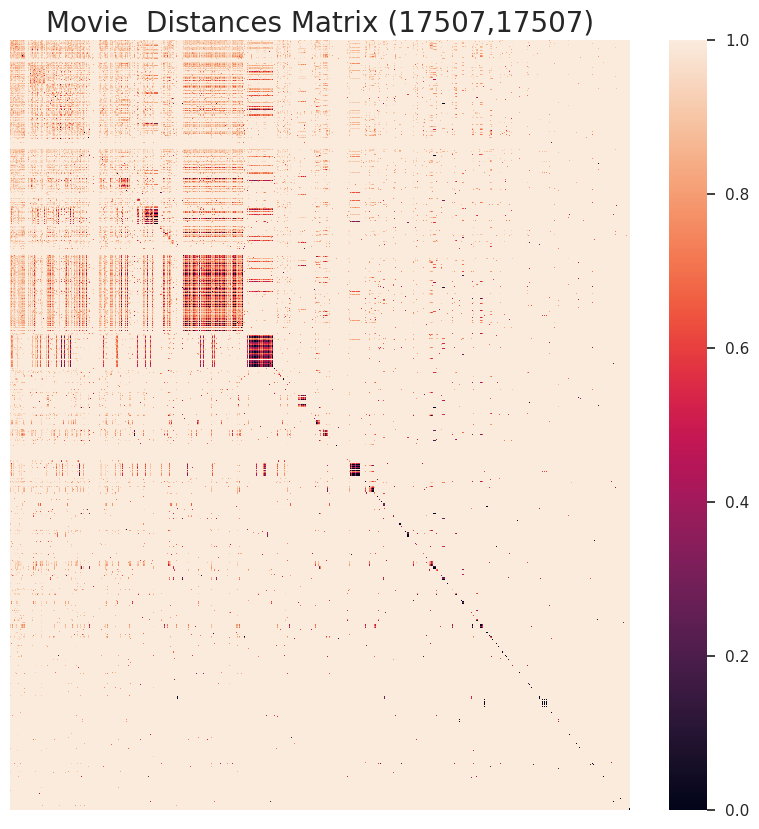

In [17]:
if TRAIN:
    item_predictor.plot()

Se guardan los modelo entrenado:

In [18]:
if TRAIN:
    user_predictor.save(WEIGHTS_PATH, 'knn-user-predictor')
    item_predictor.save(WEIGHTS_PATH, 'knn-item-predictor')

In [19]:
if TRAIN:
    user_predictor.delete()
    item_predictor.delete()

In [14]:
ut.free_gpu_memory()

In [15]:
user_predictor = ml.KNNUserBasedPredictor.from_file(WEIGHTS_PATH, 'knn-user-predictor')

In [16]:
item_predictor = ml.KNNItemBasedPredictor.from_file(WEIGHTS_PATH, 'knn-item-predictor')

Decoramos los predictores con un cache, para disminuir los tiempo de predicción, ya que no tiene sentido realizar dos veces la misma predicción para estos modelos, donde el resultado no es aleatorio:

In [17]:
cached_user_predictor = ml.CachedPredictor(user_predictor)
cached_item_predictor = ml.CachedPredictor(item_predictor)

Armamos un ensample para validar si mejora la performance de ambos modelos:

In [18]:
ensemple_predictor = ml.EnsemplePredictor([cached_user_predictor, cached_item_predictor])

## Stacking dataset


Se realiza la prediccion del modelo sobre el conjunto de evaluacion, el cual sera el conjunto de entrenamiento para el meta-modelo del stacking.

### Train dataset

In [19]:
ut.save_df(build_stacking_df(cached_user_predictor, eval_set), USER_STACKING_TRAIN_PATH)
ut.save_df(build_stacking_df(cached_item_predictor, eval_set), ITEM_STACKING_TRAIN_PATH)
ut.save_df(build_stacking_df(ensemple_predictor   , eval_set), ENSEMBLE_STACKING_TRAIN_PATH)

### Test dataset

In [20]:
ut.save_df(build_stacking_df(cached_user_predictor, test_set), USER_STACKING_TEST_PATH)
ut.save_df(build_stacking_df(cached_item_predictor, test_set), ITEM_STACKING_TEST_PATH)
ut.save_df(build_stacking_df(ensemple_predictor   , test_set), ENSEMBLE_STACKING_TEST_PATH)

## Validación del modelo

In [57]:
def validation(
    predictors, 
    n_classes,
    n_samples    = 100, 
    batch_size   = 1000, 
    n_neighbors  = N_NEIGHTBORS,
    user_index   = 0,
    summary_path = METRICS_PATH
):
    validator = ml.Validator(
        n_samples  = n_samples,
        batch_size = batch_size,
        metrics    = [
            mt.RMSE(),
            mt.MeanNdcgAtk(k=5),
            mt.MeanAveragePrecisionAtk(user_index=user_index, k=5, discretizer=dr.between(4, 5)),
            mt.MeanUserFBetaScoreAtk  (user_index=user_index, k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
            mt.MeanUserPrecisionAtk   (user_index=user_index, k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
            mt.MeanUserRecallAtk      (user_index=user_index, k=5, n_classes=n_classes, discretizer=dr.between(4, 5))
        ],
        predictors = predictors,
        y_pred_transform_fn = lambda it: it,
        y_true_transform_fn = lambda it: it.squeeze(1)
    )
    summary = validator.validate(eval_set, n_neighbors=n_neighbors)
    summary.save(summary_path)

In [58]:
validation(
    [cached_user_predictor, cached_item_predictor, ensemple_predictor],
    n_samples    = 200,
    batch_size   = 1000,
    n_neighbors  = N_NEIGHTBORS,
    summary_path = METRICS_PATH,
    n_classes    = len(dataset.target_uniques)
)

Processing:   0%|          | 0/200 [00:00<?, ?it/s]

In [59]:
summary = ml.ValidatorSummary.load(METRICS_PATH)
summary.show()

Ordered by mAP@5(4,5):


,sample,RMSE,mNDCG@5,"mAP@5(4,5)","MeanUserF1.0Score@5(4,5)","Precision@5(4,5)","Recall@5(4,5)"
predictor,,,,,,,
"Ensemple[KNNUserBasedPredictor, KNNItemBasedPredictor]",99.5,1.164085,0.955666,0.426876,0.647667,0.650015,0.647730
KNNItemBasedPredictor,99.5,1.449717,0.951977,0.423125,0.629701,0.630103,0.630375
KNNUserBasedPredictor,99.5,1.154381,0.957768,0.416697,0.598044,0.597237,0.596613


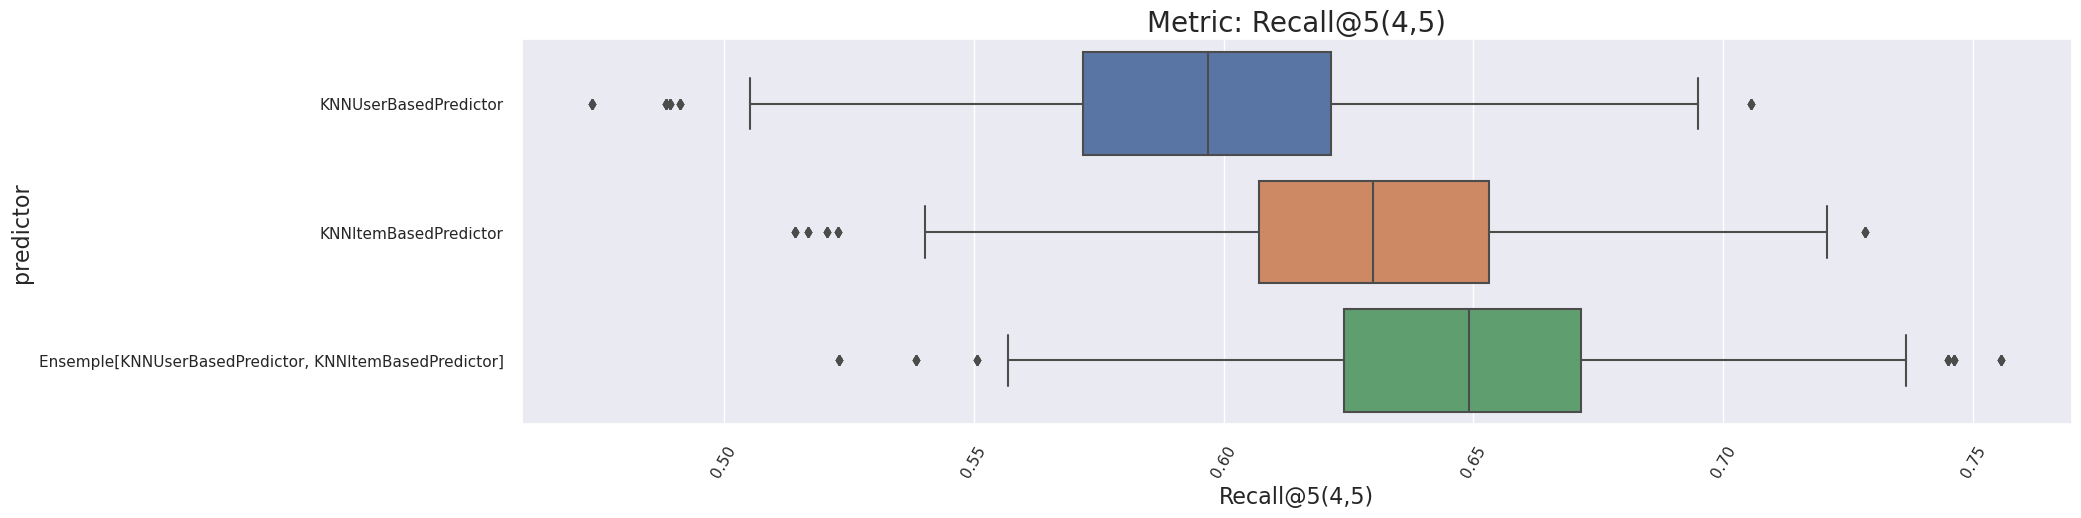

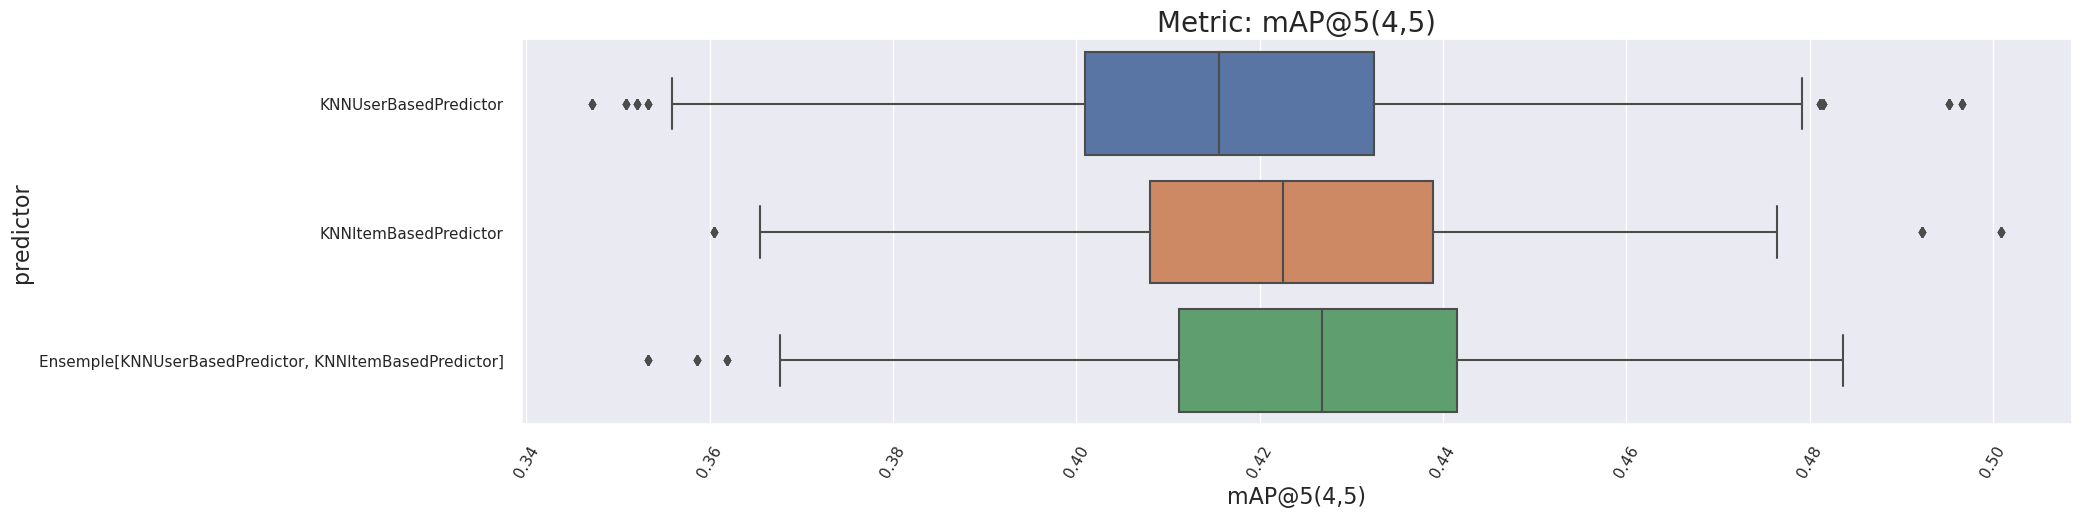

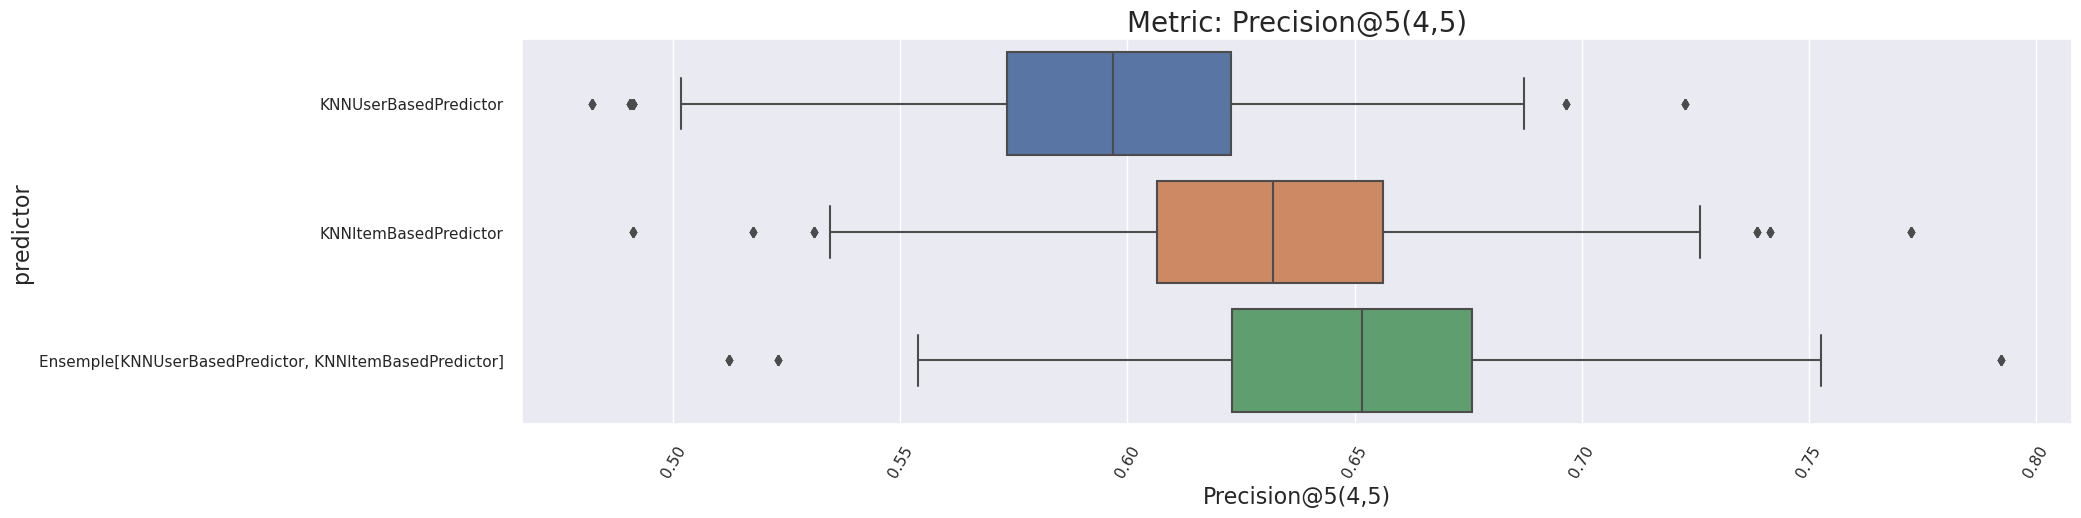

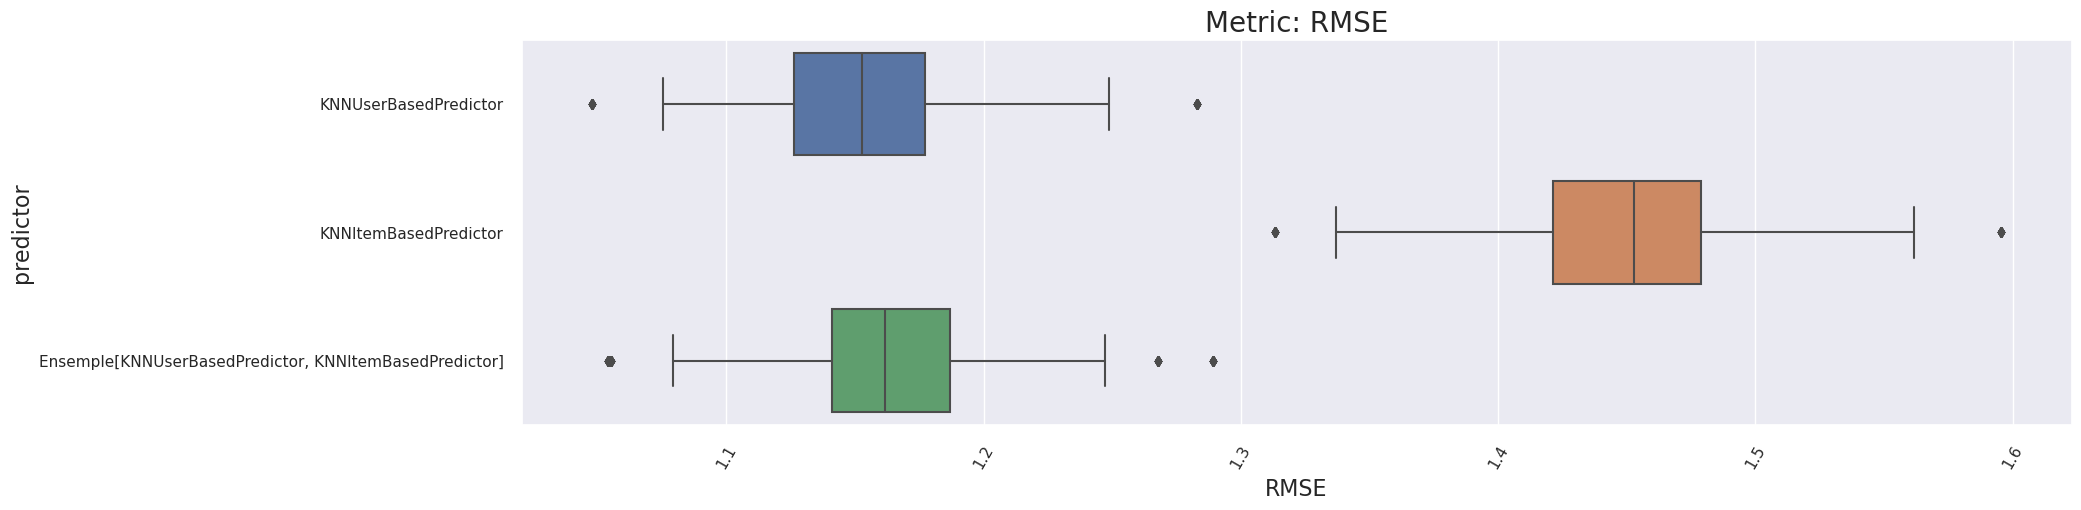

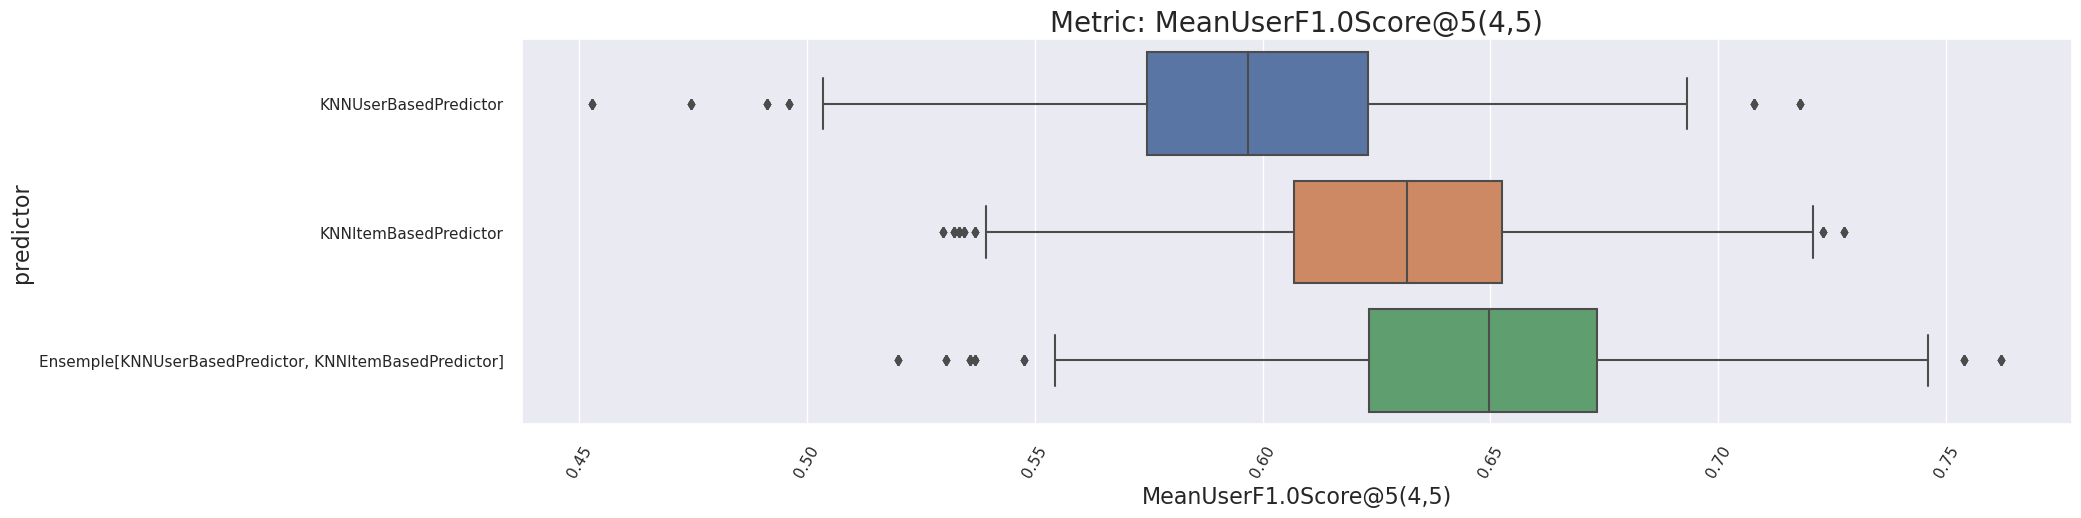

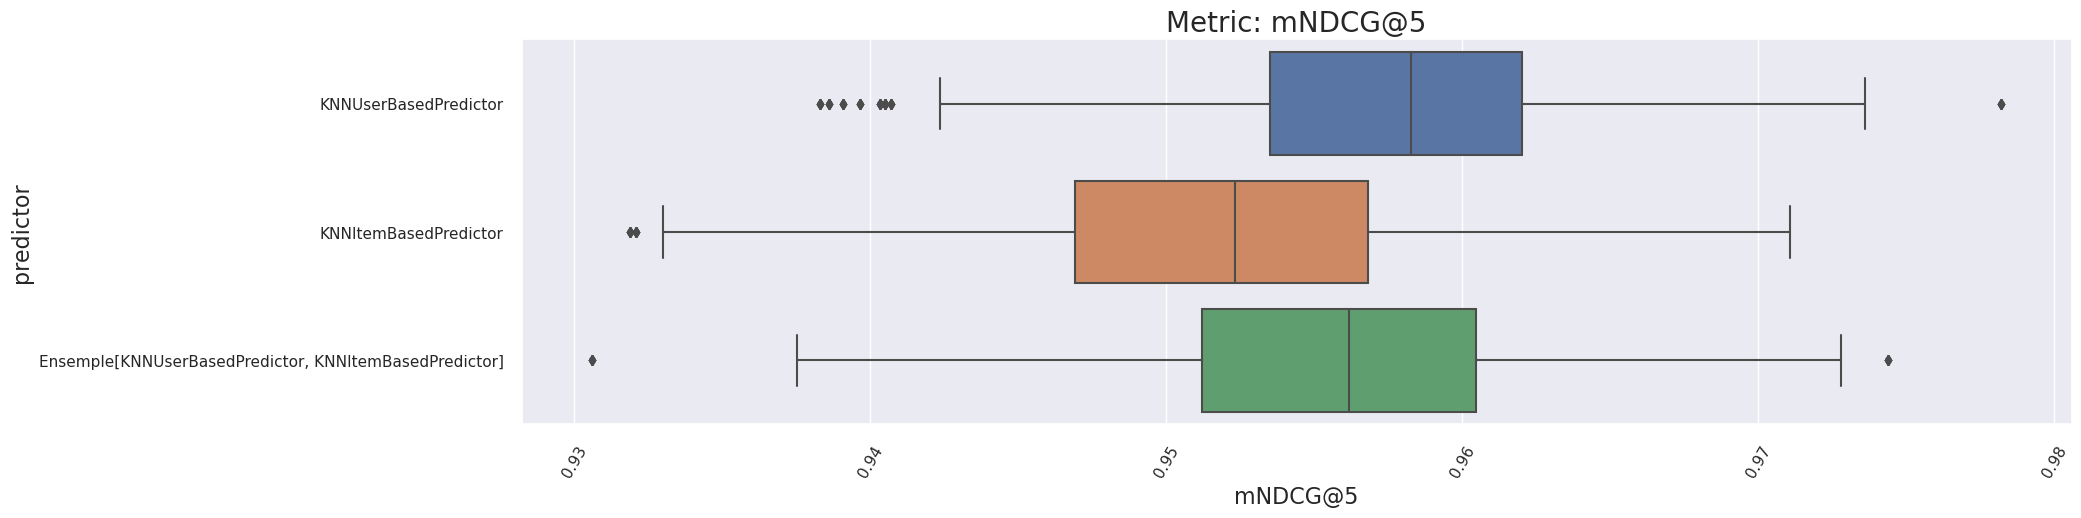

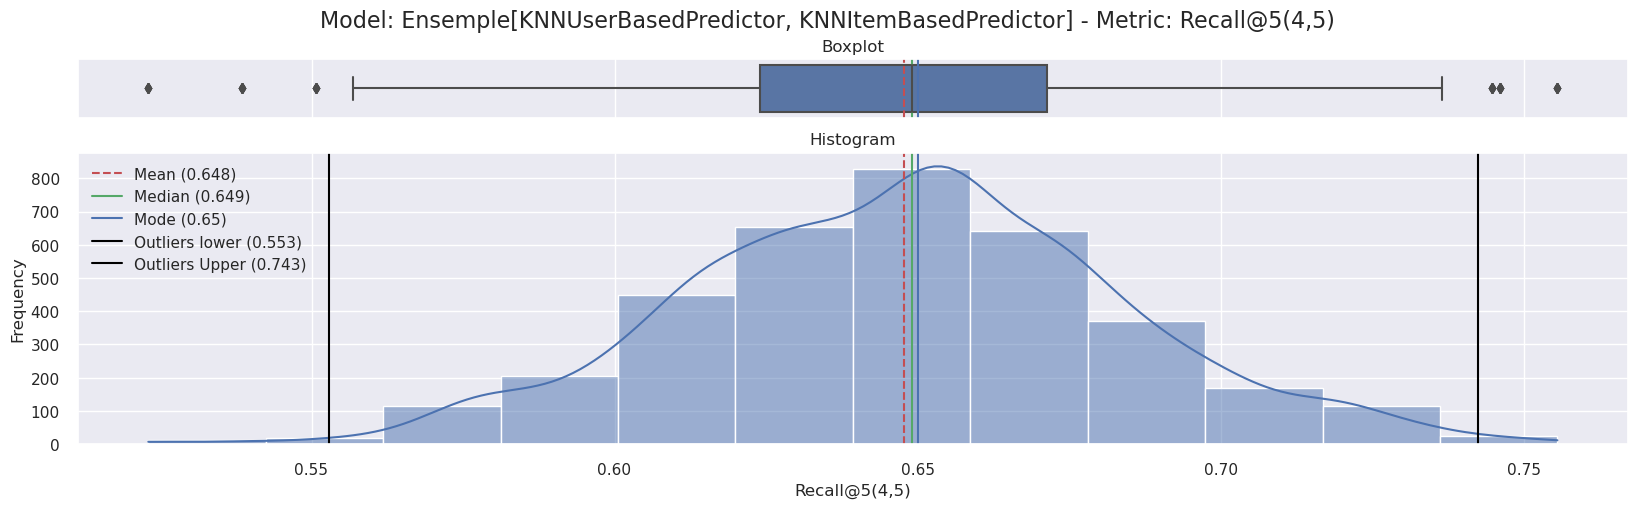

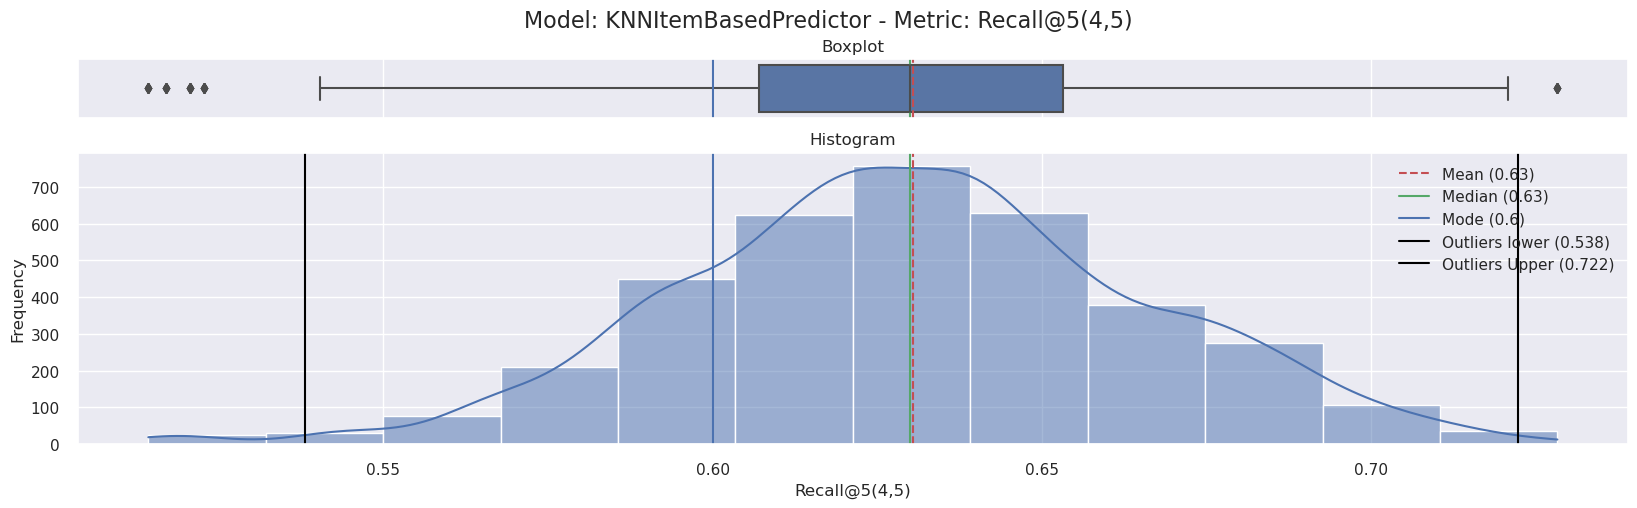

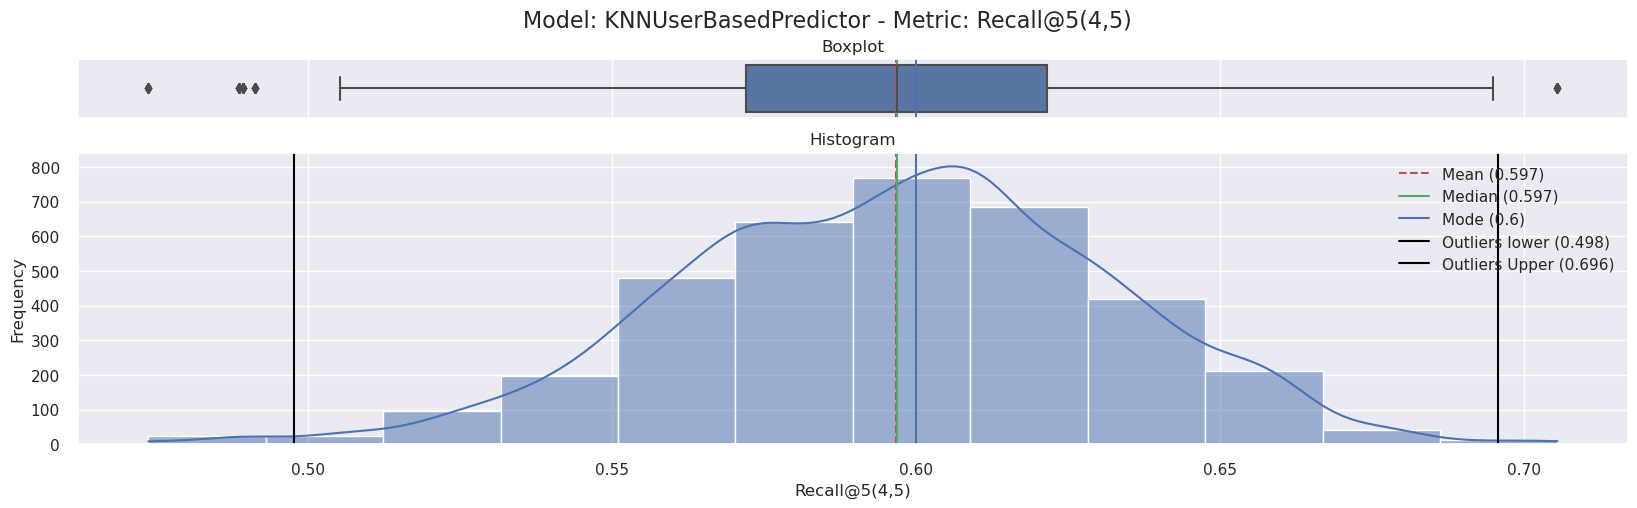

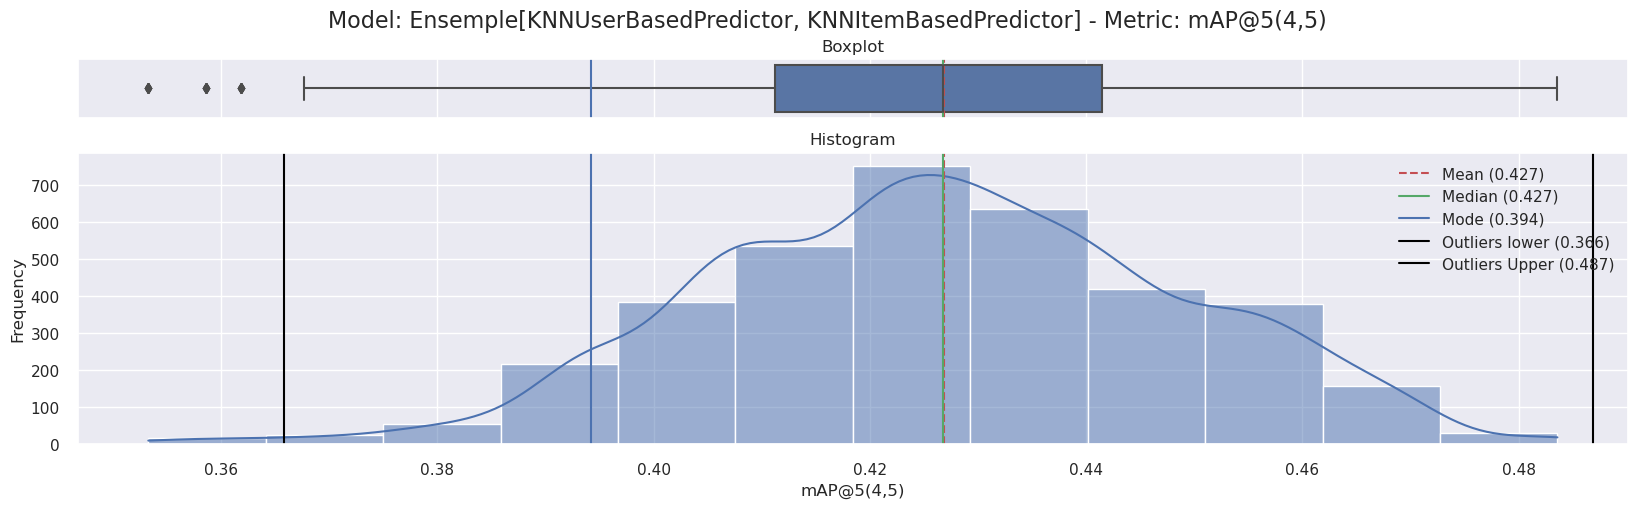

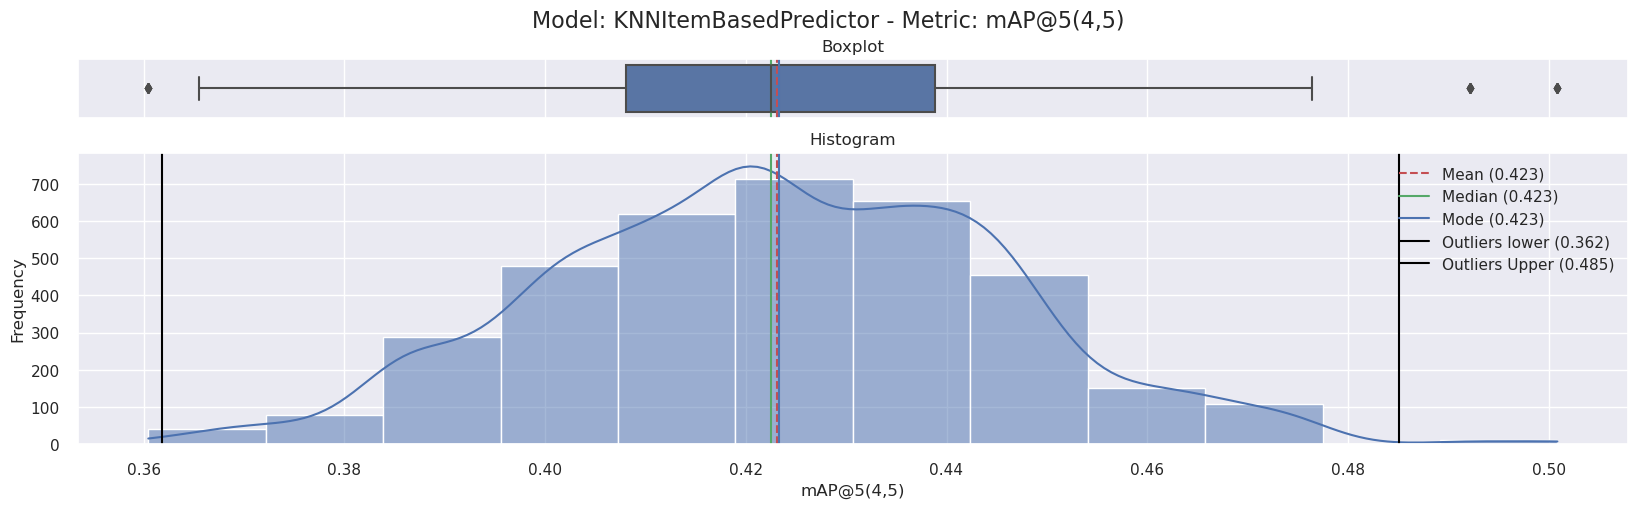

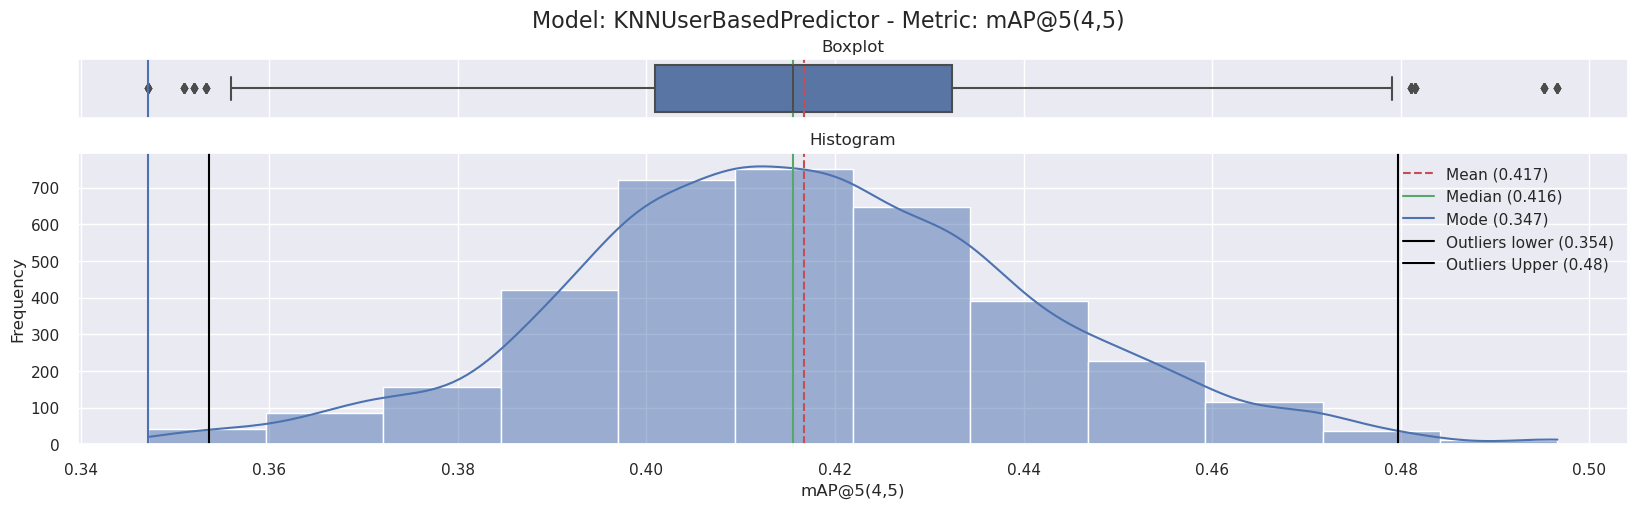

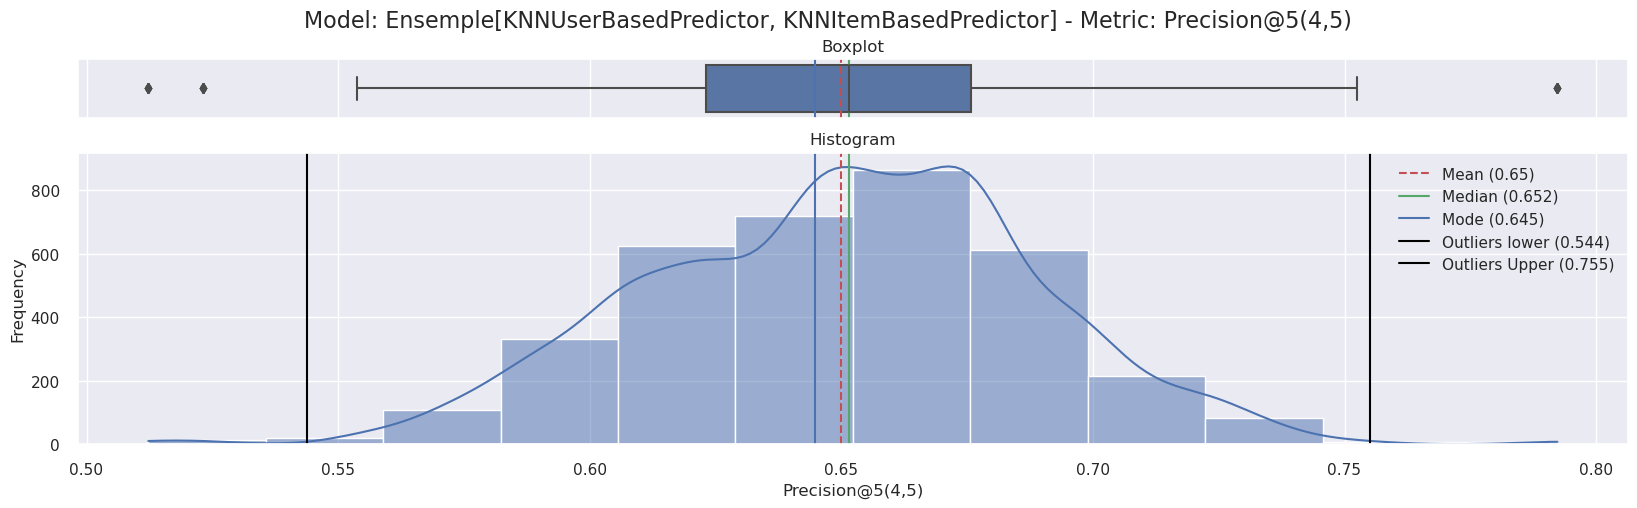

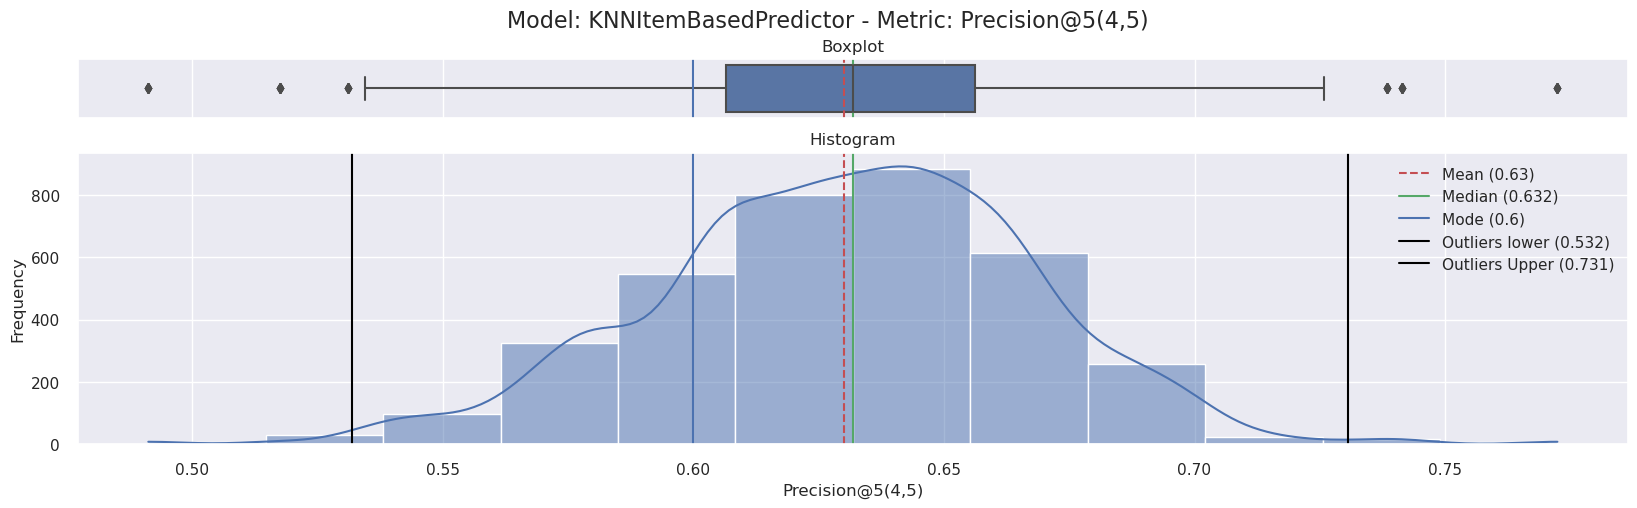

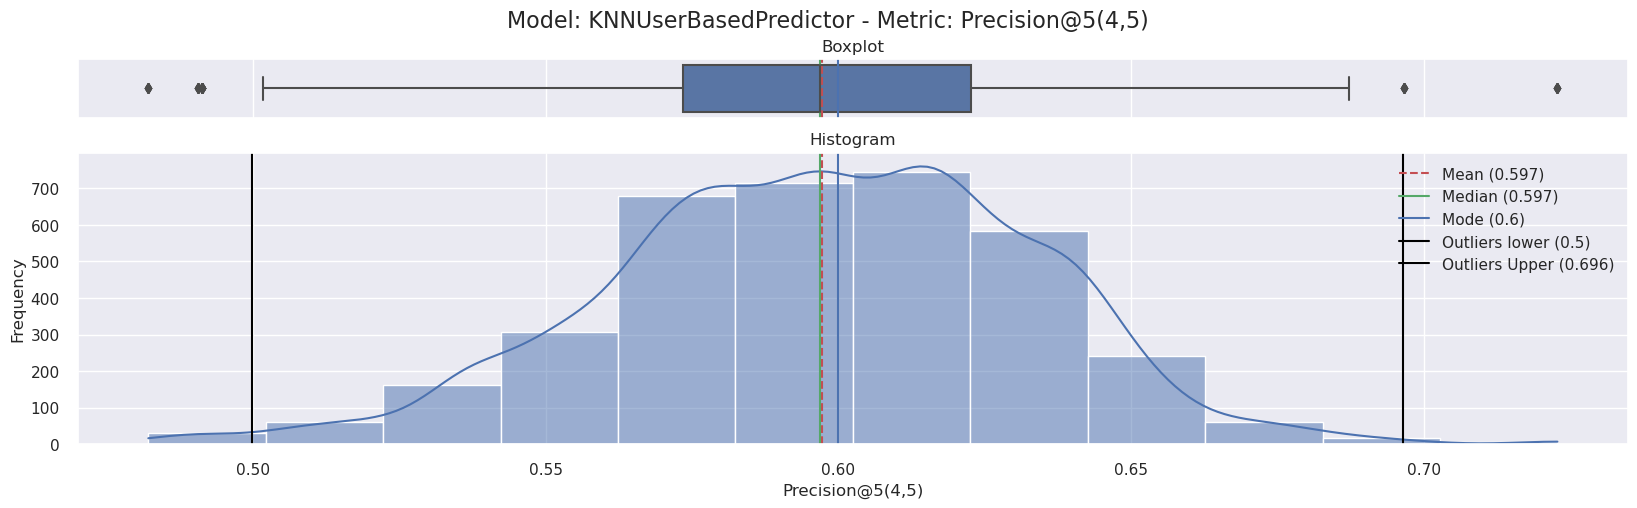

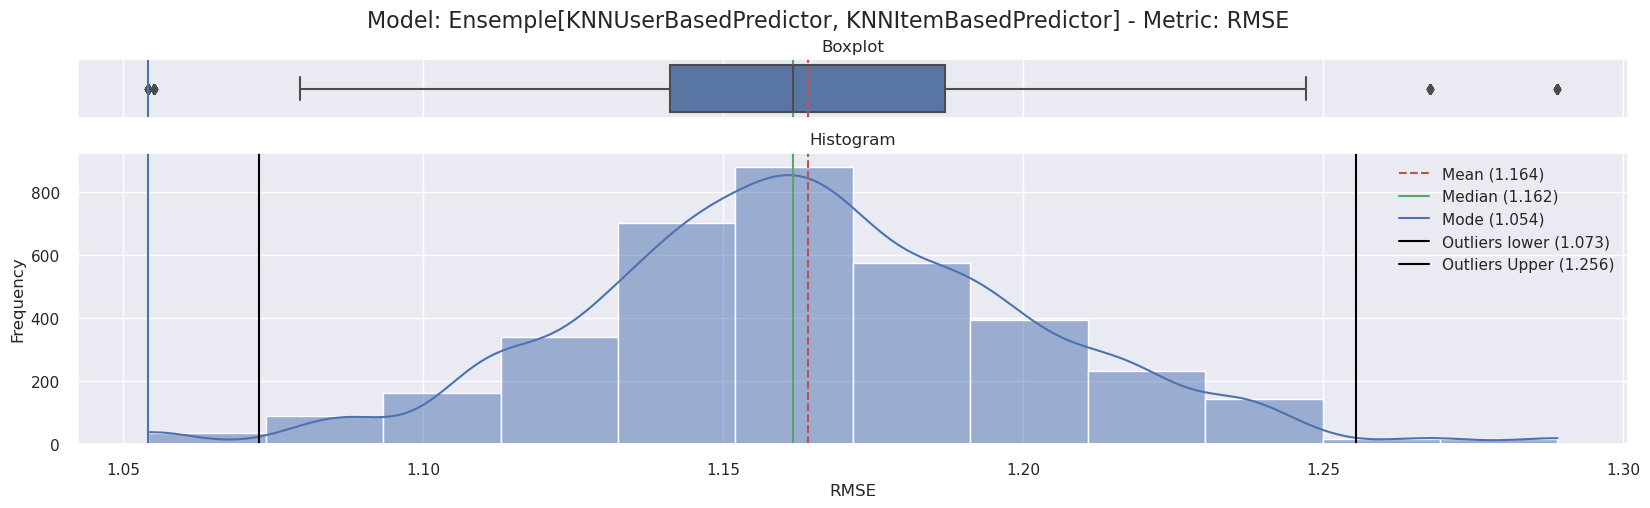

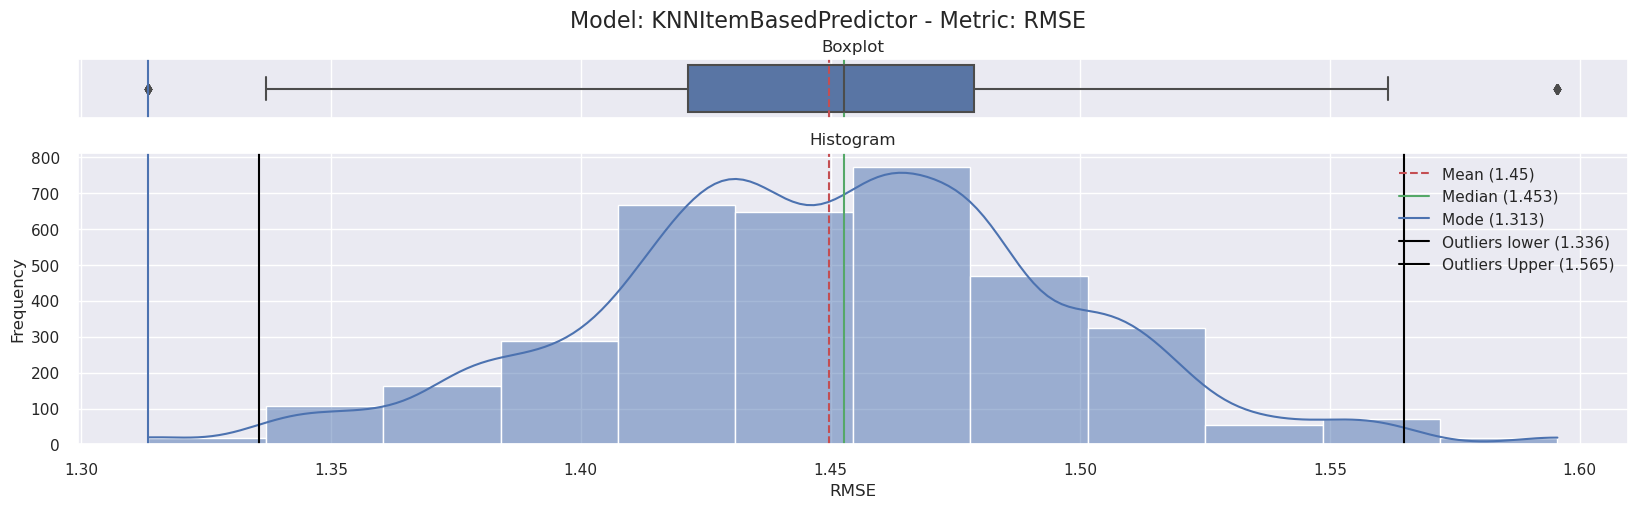

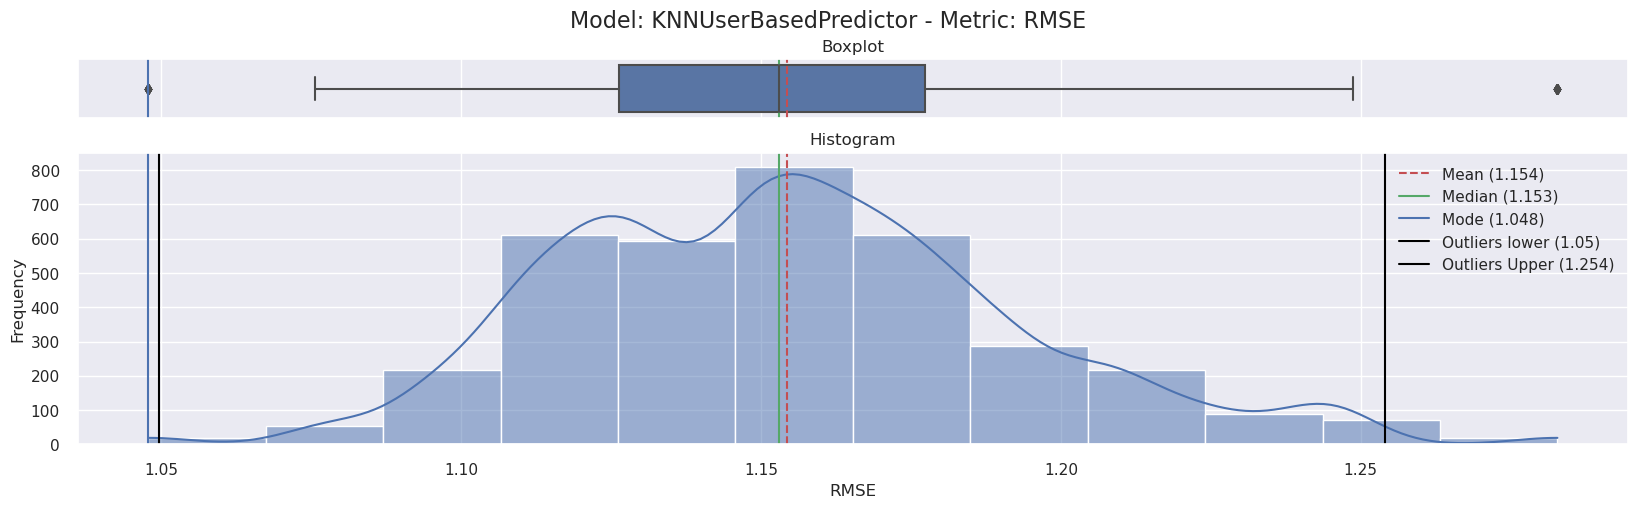

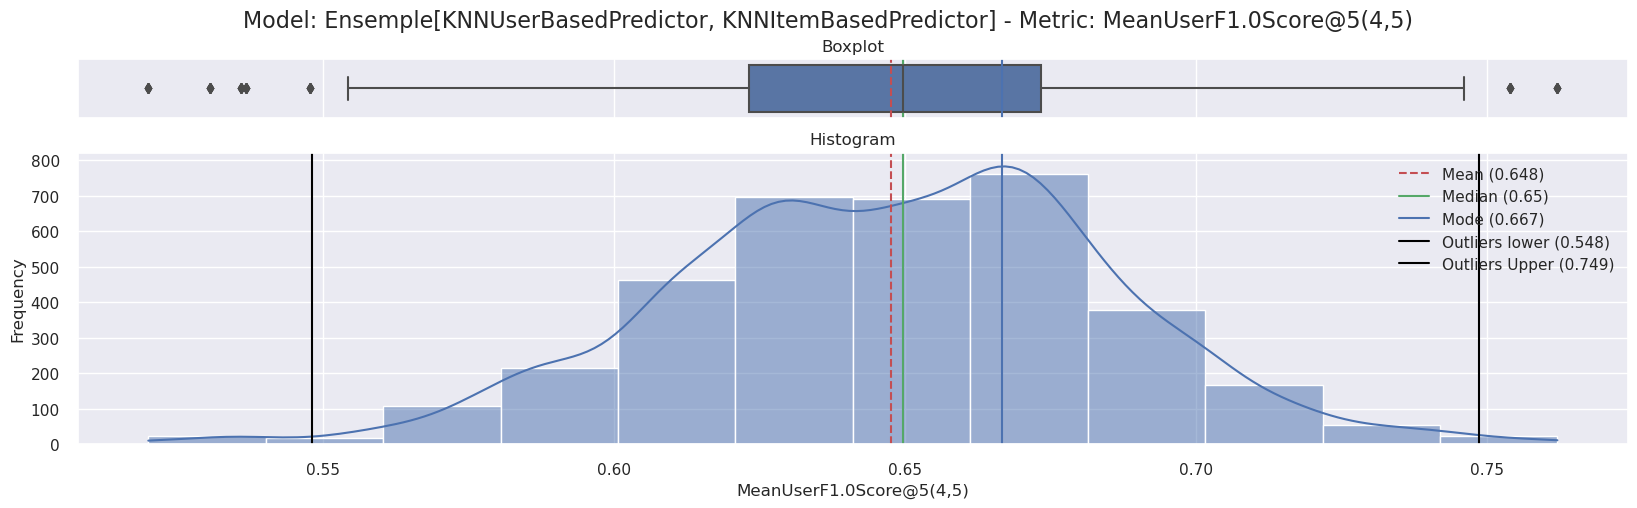

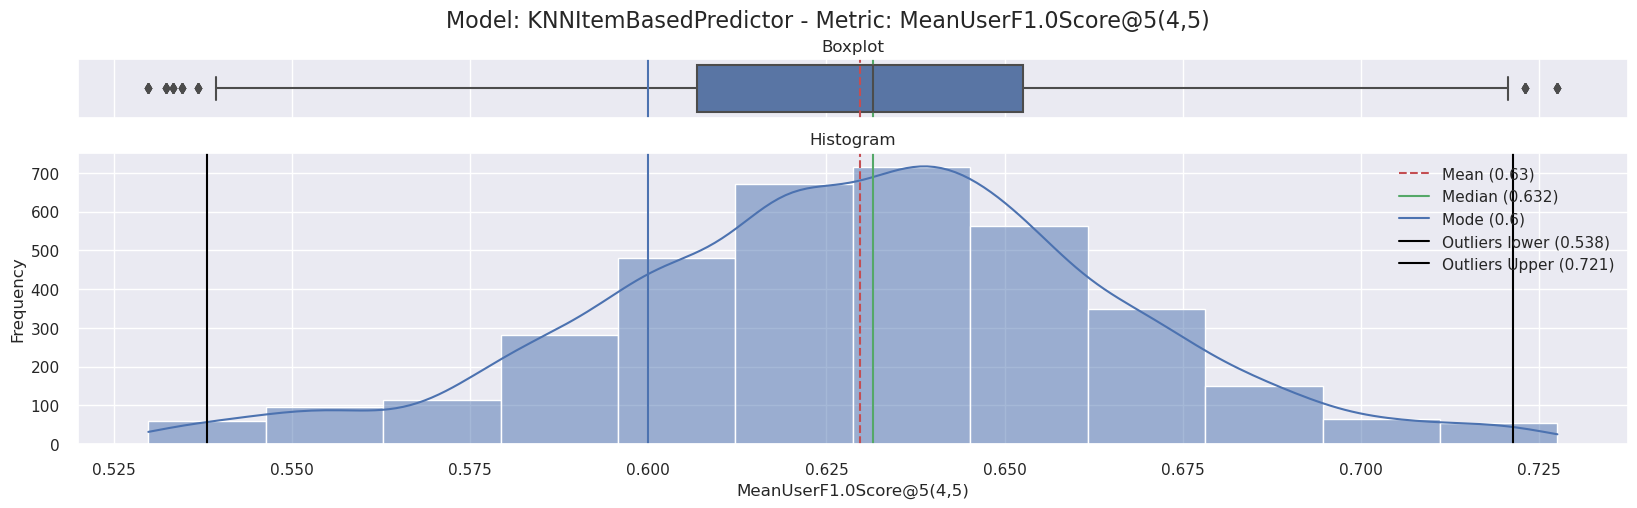

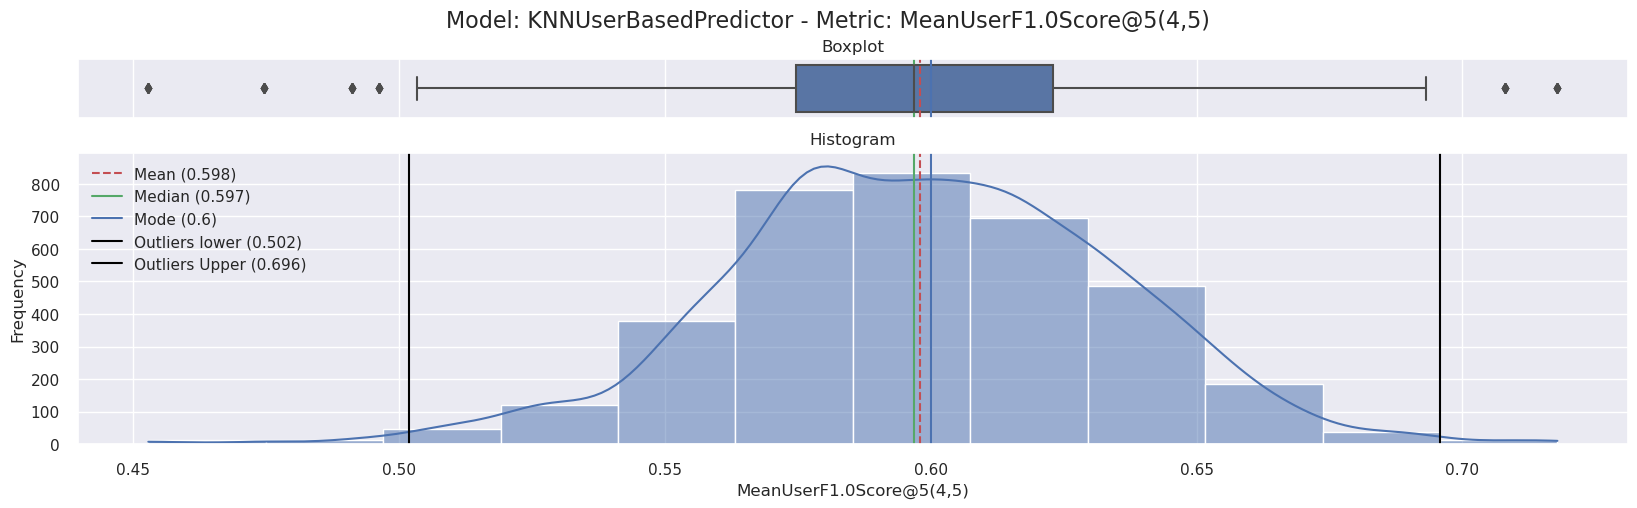

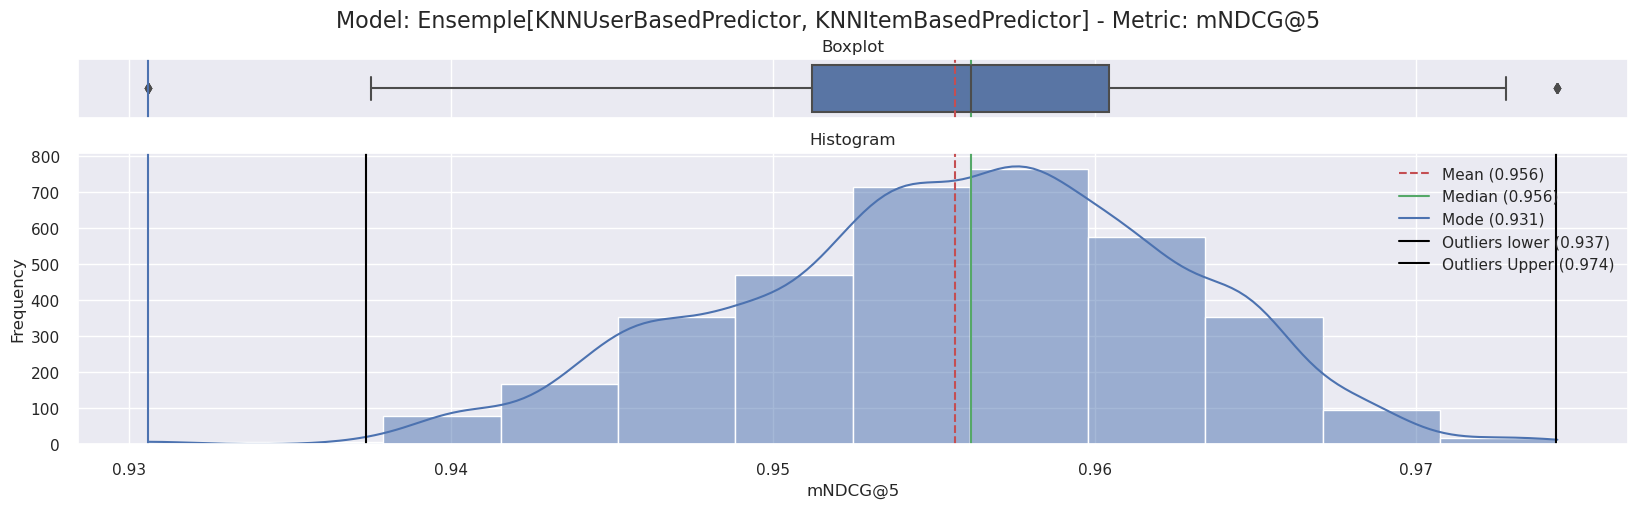

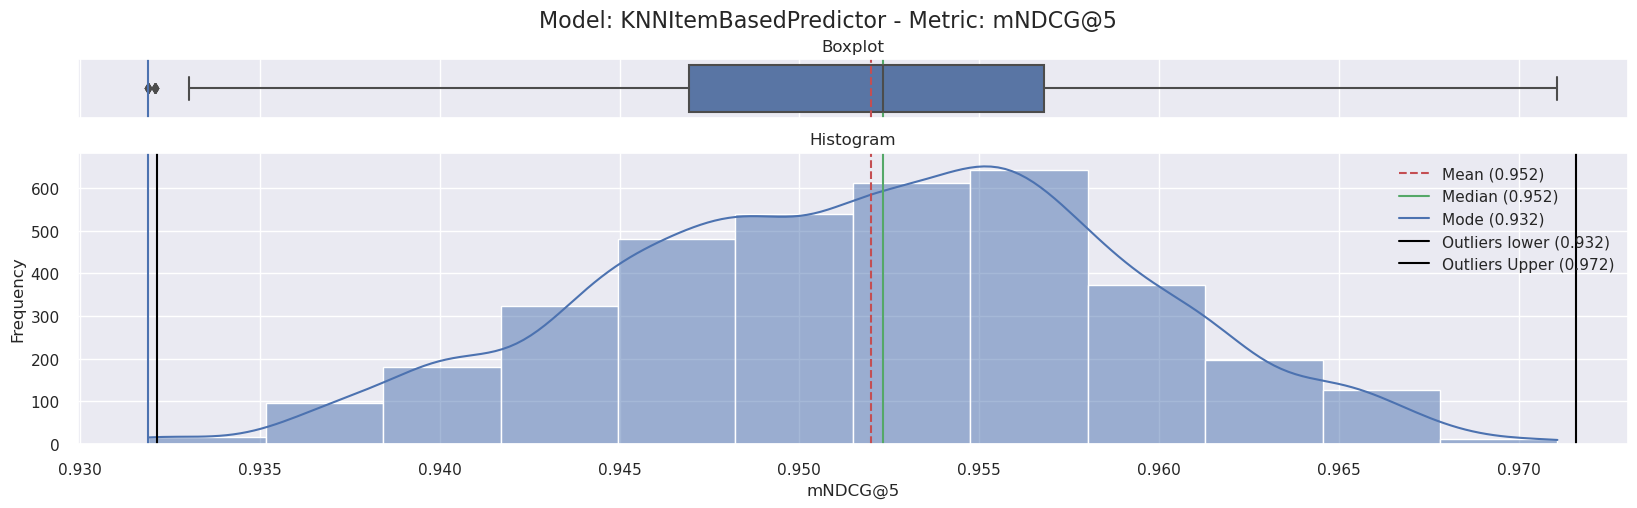

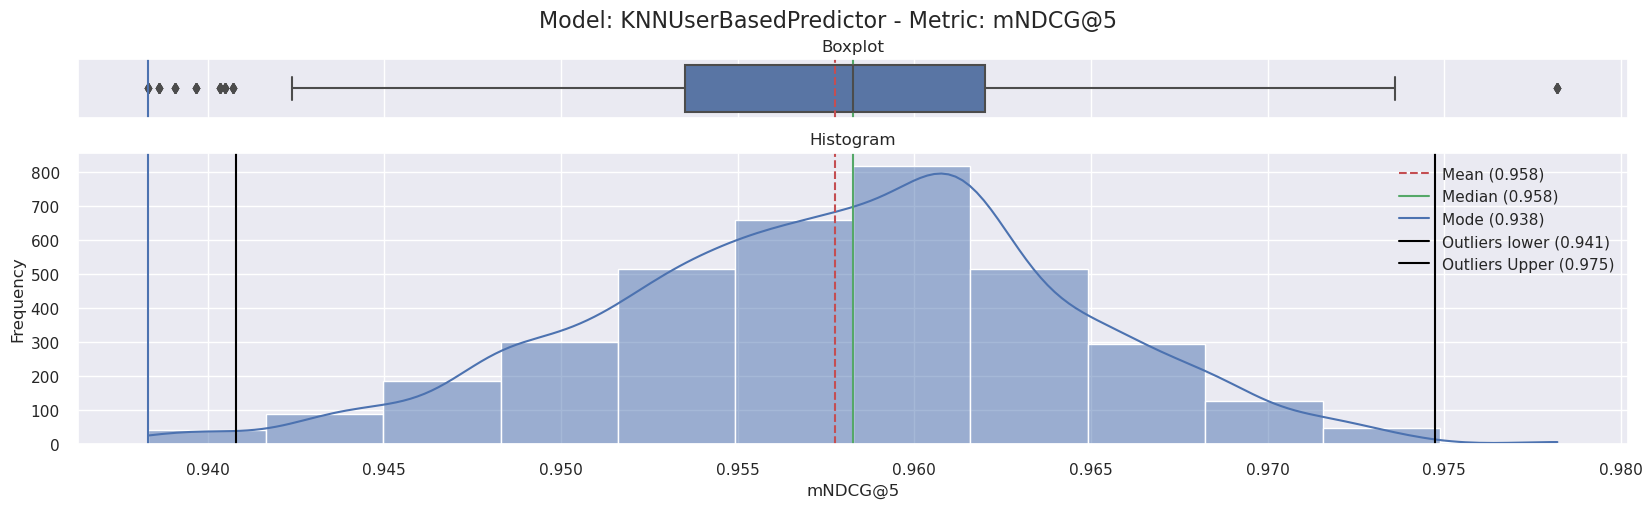

In [60]:
summary.plot(bins=12)